In [9]:
# Data Processing

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# Load the dataset
df = pd.read_csv("medical_original.csv")

# Display initial data preview
print("Initial Data Preview:")
print(df.head())

# Evaluate data structures and types
print("\nData Types Information:")
print(df.info())

# Define only the variables chosen for the analysis
selected_columns = [
    'ReAdmis', 'Initial_days', 'Age', 'Income', 'Doc_visits',  # Continuous Variables
    'Complication_risk', 'Initial_admin', 'HighBlood', 'Stroke', 'Diabetes', 'Hyperlipidemia'  # Categorical Variables
]

# Keep only selected columns and drop rows with missing values
df_cleaned = df[selected_columns].dropna()

# Identify categorical and numerical columns
categorical_vars_multi = ['Complication_risk', 'Initial_admin']  # More than 2 categories
categorical_vars_binary = ['HighBlood', 'Stroke', 'Diabetes', 'Hyperlipidemia']  # Only 2 categories
continuous_vars = ['Initial_days', 'Age', 'Income', 'Doc_visits']

# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from numerical columns
for col in continuous_vars:
    if col in df_cleaned.columns:
        df_cleaned = remove_outliers(df_cleaned, col)

# Convert the target variable "ReAdmis" (Yes/No) into binary values (0 = No, 1 = Yes)
df_cleaned['ReAdmis'] = df_cleaned['ReAdmis'].map({'No': 0, 'Yes': 1})

# Apply One-Hot Encoding to categorical variables with more than two categories
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_vars_multi, drop_first=False)  # Keep all categories

# Apply Label Encoding to binary categorical variables
label_encoders = {}
for col in categorical_vars_binary:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Store encoder for future decoding if needed

# Scale the numerical features
scaler = StandardScaler()
df_cleaned[continuous_vars] = scaler.fit_transform(df_cleaned[continuous_vars])

# Ensure `ReAdmis` is still in the dataset before saving
if 'ReAdmis' not in df_cleaned.columns:
    raise ValueError("Error: 'ReAdmis' column was removed during preprocessing!")

# Save cleaned dataset
df_cleaned.to_csv("medical_cleaned.csv", index=False)
print("\nData cleaning and preprocessing completed successfully!")



Initial Data Preview:
   CaseOrder Customer_id                           Interaction  \
0          1     C412403  8cd49b13-f45a-4b47-a2bd-173ffa932c2f   
1          2     Z919181  d2450b70-0337-4406-bdbb-bc1037f1734c   
2          3     F995323  a2057123-abf5-4a2c-abad-8ffe33512562   
3          4     A879973  1dec528d-eb34-4079-adce-0d7a40e82205   
4          5     C544523  5885f56b-d6da-43a3-8760-83583af94266   

                                UID          City State        County    Zip  \
0  3a83ddb66e2ae73798bdf1d705dc0932           Eva    AL        Morgan  35621   
1  176354c5eef714957d486009feabf195      Marianna    FL       Jackson  32446   
2  e19a0fa00aeda885b8a436757e889bc9   Sioux Falls    SD     Minnehaha  57110   
3  cd17d7b6d152cb6f23957346d11c3f07  New Richland    MN        Waseca  56072   
4  d2f0425877b10ed6bb381f3e2579424a    West Point    VA  King William  23181   

        Lat       Lng  ...  TotalCharge Additional_charges Item1 Item2  Item3  \
0  34.34960 -86.725

In [11]:
# Train & Test Split

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv("medical_cleaned.csv")

# Define features (X) and target variable (y)
X = df.drop(columns=['ReAdmis'])  # Drop target variable from features
y = df['ReAdmis']  # Target variable

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine features and target variable for training and testing sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save the training and test sets as CSV files
train_data.to_csv("medical_train.csv", index=False)
test_data.to_csv("medical_test.csv", index=False)

# Print confirmation message
print("Dataset split complete.")
print("Training data saved as 'medical_train.csv'")
print("Testing data saved as 'medical_test.csv'")


Dataset split complete.
Training data saved as 'medical_train.csv'
Testing data saved as 'medical_test.csv'



Training Set Size: (7739, 14)
Testing Set Size: (1935, 14)
Number of Features: 14

First 5 Training Samples (Features):
   Initial_days       Age    Income  Doc_visits  HighBlood  Stroke  Diabetes  \
0     -0.723980 -1.722136  1.978340   -0.969633          1       0         0   
1      1.079676  0.506094 -0.679193   -0.010901          0       0         0   
2      1.412180 -0.559581  0.103013   -0.010901          1       0         0   
3     -0.955990 -1.383057  0.310998   -0.010901          0       0         0   
4      1.217075 -0.268942  0.260506    0.947830          0       0         0   

   Hyperlipidemia  Complication_risk_High  Complication_risk_Low  \
0               0                    True                  False   
1               1                   False                  False   
2               0                   False                  False   
3               0                   False                  False   
4               0                   False                 

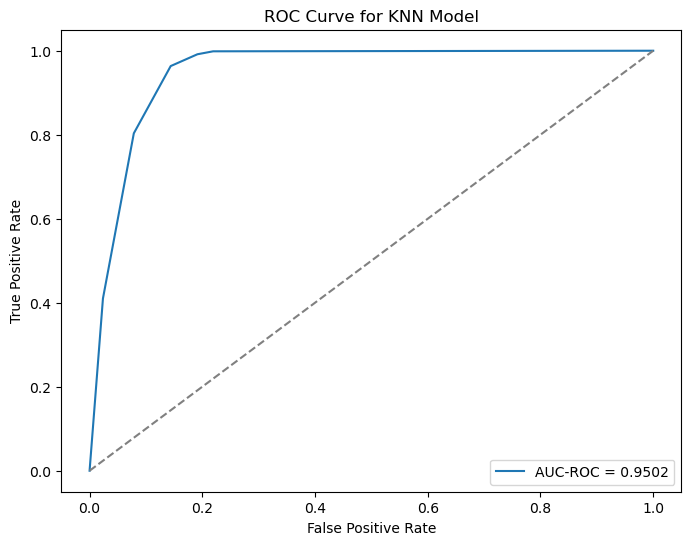

In [13]:
# KNN Classification Model with Intermediate Calculations

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Load the training and test sets
train_df = pd.read_csv("medical_train.csv")
test_df = pd.read_csv("medical_test.csv")

# Define features (X) and target variable (y) for training and testing sets
X_train = train_df.drop(columns=['ReAdmis'])  # Features for training
y_train = train_df['ReAdmis']  # Target for training

X_test = test_df.drop(columns=['ReAdmis'])  # Features for testing
y_test = test_df['ReAdmis']  # Target for testing

# Print basic dataset statistics
print("\nTraining Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)
print("Number of Features:", X_train.shape[1])

# Initialize and train the KNN model
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Print the first 5 training samples
print("\nFirst 5 Training Samples (Features):")
print(X_train.head())

# Print the first 5 test samples
print("\nFirst 5 Test Samples (Features):")
print(X_test.head())

# Select a sample test point (first test example)
sample_test_point = X_test.iloc[0:1]  # First row for debugging

# Find the 5 nearest neighbors for this test point
distances, indices = knn.kneighbors(sample_test_point)

print("\nNearest Neighbors for First Test Sample:")
print("Distances:", distances)
print("Indices of Neighbors in Training Set:", indices)

# Print feature values of the 5 nearest neighbors
print("\nFeature Values of 5 Nearest Neighbors:")
print(X_train.iloc[indices[0]])

# Predict class probabilities for all test samples
y_pred_proba = knn.predict_proba(X_test)

# Print probability distribution for first 5 test samples
print("\nFirst 5 Probability Predictions (Columns: Class 0, Class 1):")
print(y_pred_proba[:5])

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Print first 5 predictions
print("\nFirst 5 Predictions:", y_pred[:5])
print("First 5 Actual Labels:", y_test.values[:5])

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Print evaluation metrics
print(f"\nKNN Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Print Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for KNN Model")
plt.legend()
plt.show()
